In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
def verify(src_data, dec_data):
    """
    Compare the decompressed data with original data
    :param src_data: original data, numpy array
    :param dec_data: decompressed data, numpy array
    :return: max_diff, psnr, nrmse
    """
    data_range = np.max(src_data) - np.min(src_data)
    diff = src_data - dec_data
    max_diff = np.max(abs(diff))
    # print("abs err={:.8G}".format(max_diff))
    mse = np.mean(diff ** 2)
    nrmse = np.sqrt(mse) / data_range
    psnr = 20 * np.log10(data_range) - 10 * np.log10(mse)
    return  psnr
import ctypes 
def qcatssim(orig:np.ndarray[np.float32], decompressed:np.ndarray[np.float32]):
    dims = np.array(orig.shape)[::-1]
    # print(dims)
    lib = ctypes.CDLL('/home/pji228/workspace/git/draft/artifact/compress_scripts/aramco_ssim/qcatssim_py.dylib')
    lib.calculateSSIM.restype = ctypes.c_double
    lib.calculateSSIM.argtypes = [np.ctypeslib.ndpointer(dtype=np.float32),
                              np.ctypeslib.ndpointer(dtype=np.float32),
                              np.ctypeslib.ndpointer(dtype=np.int32),
                              ctypes.c_int]
    result =lib.calculateSSIM(
        orig, 
        decompressed,
        dims.astype(np.int32), 
        ctypes.c_int(dims.size))
    return result 

In [73]:
orig = np.fromfile("/project/xli281_uksr/pjiao/data/miranda/velocityx.f32", dtype=np.float32).reshape(256,384,384)
decompressed = np.fromfile("../build/test.q", dtype=np.float32).reshape(256,384,384) 
global_compression = np.fromfile("../build/test.c", dtype=np.float32).reshape(256,384,384)
# global_compression = np.fromfile("../build/test.c.out", dtype=np.float32).reshape(256,384,384)
local_compensation = np.fromfile("../build/block_compensated.nocommunication.f32", dtype=np.float32).reshape(256,384,384) 
boundary_exchange = np.fromfile("../build/block_compensated.boun_exchange.f32", dtype=np.float32).reshape(256,384,384)
edt_opt = np.fromfile("../build/block_compensated.edt_opt.f32", dtype=np.float32).reshape(256,384,384) 
edt_bound = np.fromfile("../build/block_compensated.edt_bound.f32", dtype=np.float32).reshape(256,384,384)
# block_compression = np.fromfile("../build/block_compensated.vx.f32", dtype=np.float32).reshape(256,384,384) 
# block_compression = np.fromfile("../build/block_compensated.4x4x4.vx.f32", dtype=np.float32).reshape(256,384,384) 
# test.c.out

psnr = [verify(orig, decompressed),
        verify(orig, local_compensation),
        verify(orig, global_compression),
        verify(orig, boundary_exchange),
        verify(orig, edt_opt),
        verify(orig, edt_bound)]
print("psnr: ", psnr)
ssim = [qcatssim(orig, decompressed),
        qcatssim(orig, local_compensation),
        qcatssim(orig, global_compression),
        qcatssim(orig, boundary_exchange),
        qcatssim(orig, edt_opt),
        qcatssim(orig, edt_bound)]
print("ssim: ", ssim)
# plot the data 

psnr:  [65.14651536941528, 68.76328229904175, 69.1278862953186, 69.09391164779663, 68.75798463821411, 69.00541067123413]
ssim:  [0.5232039047593174, 0.8564535792614473, 0.8835401193951449, 0.8754158119250047, 0.8531298635450527, 0.8619627419142987]


In [79]:
e_decomposed = orig - decompressed
e_global_compression = orig - global_compression
e_local_compensation = orig - local_compensation
e_boundary_exchange = orig - boundary_exchange
e_edt_opt = orig - edt_opt
e_edt_bound = orig - edt_bound
errors = [e_decomposed, e_local_compensation,  e_global_compression, e_boundary_exchange, e_edt_opt, e_edt_bound] 
error_tags = ["original error", "global compression", "local compensation", "Quant exchange", "edt_opt", "edt_opt + Quant exchange"]
decompdessed_data = [decompressed, local_compensation, global_compression,  boundary_exchange, edt_opt, edt_bound]
# Titles = ["Original Error", "Global Compression", "Local Compensation", "Quantization Exchange", "EDT Optimization", "EDT + Quantization Exchange"]
Titles = ["Original Error", "Local Compensation", "Global Compression",  "Optimized Global Compensation", "EDT Optimization", "EDT + Quantization Exchange"]
## exchange index 1 and index 2 


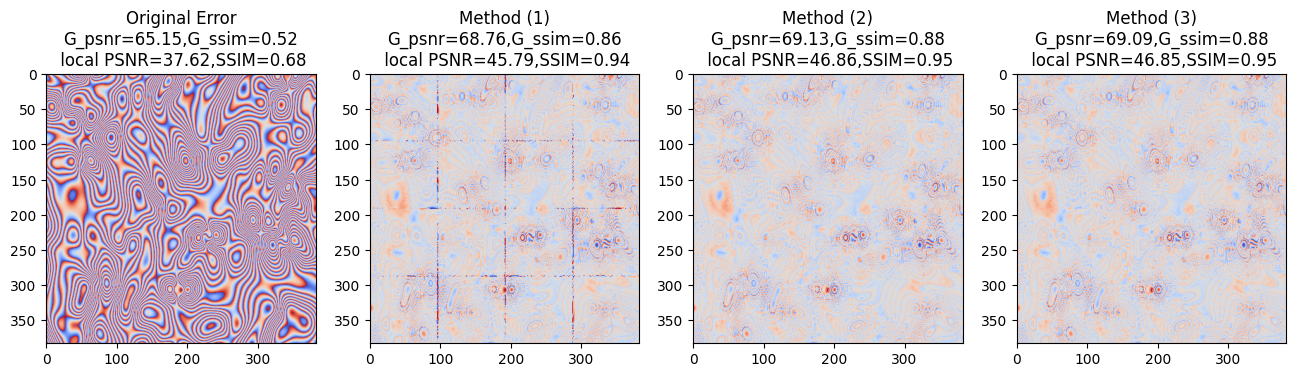

In [75]:
picks = [0,1,2,3]
s_xlice = 81
x1 = 0
x2 = -1
y1 = 0
y2 = -1 
local_psnr = []
local_ssim = []
for i in picks:
    local_psnr.append(verify(orig[s_xlice, x1:x2, y1:y2].copy(), decompdessed_data[i][s_xlice, x1:x2, y1:y2].copy()))
    local_ssim.append(qcatssim(orig[s_xlice, x1:x2, y1:y2].copy(), decompdessed_data[i][s_xlice, x1:x2, y1:y2].copy()))
figs, axs = plt.subplots(1, 4, figsize=(16, 4))
max_val = np.max(np.abs(e_decomposed[s_xlice, x1:x2, y1:y2]))
min_val = max_val*-1.0
for i in picks: 
    axs[i].imshow(errors[i][s_xlice, x1:x2, y1:y2], cmap='coolwarm', vmin=min_val, vmax=max_val)
    axs[i].set_title(Titles[i]+"\nG_psnr={:.2f},G_ssim={:.2f}\n local PSNR={:.2f},SSIM={:.2f}".format(psnr[i], ssim[i],local_psnr[i], local_ssim[i]))
    # axs[i].axis('off')
# plt.colorbar(axs[0].imshow(errors[0][s_xlice, x1:x2, y1:y2], cmap='jet', vmin=min_val, vmax=max_val))
# plt.savefig("error.png", dpi=300)
plt.show()



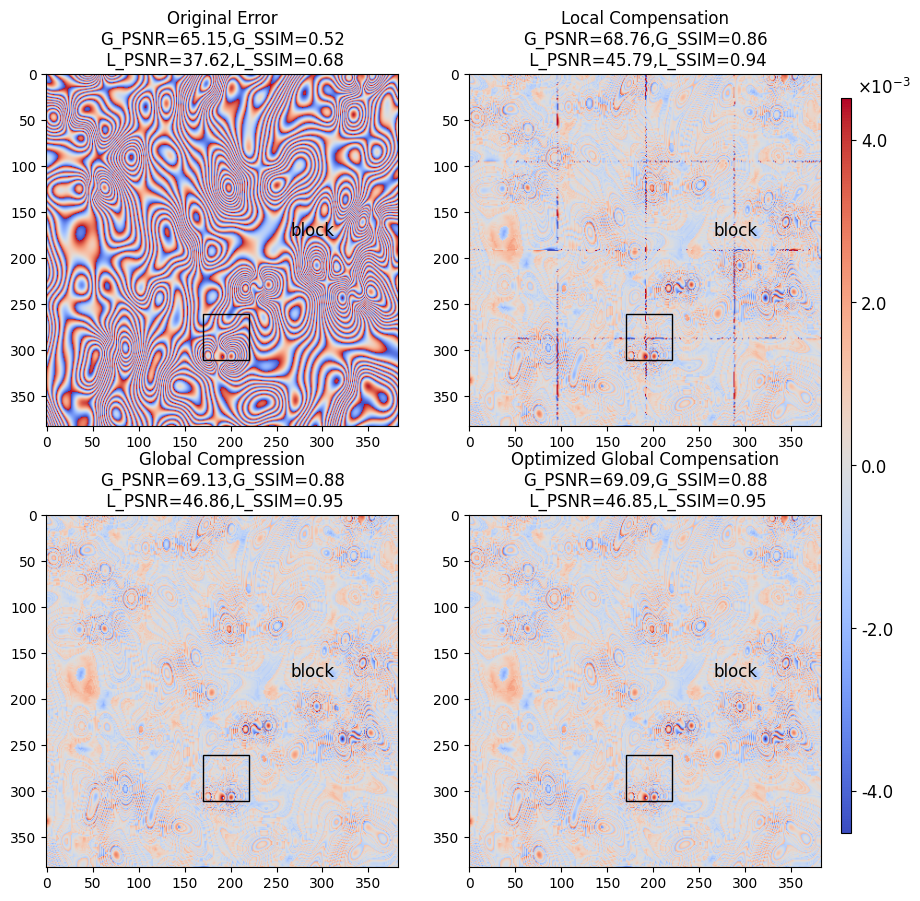

In [ ]:
s_xlice = 81
x1 = 0
x2 = -1
y1 = 0
y2 = -1 
local_psnr = []
local_ssim = []
for i in picks :
    local_psnr.append(verify(orig[s_xlice, x1:x2, y1:y2].copy(), decompdessed_data[i][s_xlice, x1:x2, y1:y2].copy()))
    local_ssim.append(qcatssim(orig[s_xlice, x1:x2, y1:y2].copy(), decompdessed_data[i][s_xlice, x1:x2, y1:y2].copy()))
figs, axs = plt.subplots(2, 2, figsize=(10, 10.5))
max_val = np.max(np.abs(e_decomposed[s_xlice, x1:x2, y1:y2]))
min_val = max_val*-1.0
for i in picks: 
    axs[i//2,i%2].imshow(errors[i][s_xlice, x1:x2, y1:y2], cmap='coolwarm', vmin=min_val, vmax=max_val)
    axs[i//2,i%2].set_title(Titles[i]+"\nG_PSNR={:.2f},G_SSIM={:.2f}\n L_PSNR={:.2f},L_SSIM={:.2f}".format(psnr[i], ssim[i],local_psnr[i], local_ssim[i]))
    # axs[i].axis('off')
# plt.colorbar(axs[0].imshow(errors[0][s_xlice, x1:x2, y1:y2], cmap='jet', vmin=min_val, vmax=max_val))
# plt.savefig("error.png", dpi=300)
# put colorbar on the right side of the plot
cbar_ax = figs.add_axes([0.92, 0.15, 0.01, 0.7])
cbar = figs.colorbar(axs[0, 0].imshow(errors[0][s_xlice, x1:x2, y1:y2], 
                                      cmap='coolwarm', vmin=min_val, vmax=max_val), cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  # Set tick label size

# make the colorbar text as scientific notation 
def scientific_fmt(x, pos):
    return f'{x * 1e3:.1f}'  # scale up values so tick labels look like -5.0, ..., 5.0
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter

# formatter = ScalarFormatter(useMathText=True)
# formatter.set_powerlimits((-2, 2))  # Force scientific notation for values outside this range
# cbar.ax.yaxis.set_major_formatter(formatter)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(scientific_fmt))
cbar.ax.yaxis.offsetText.set_visible(False)

b_x1 = 260-x1 
b_x2 =  50 
b_y1 = 170 -y1 
b_y2 = 50 
# add a rectangle to each subplot using the add_patch method 
for i in picks:
    axs[i//2,i%2].add_patch(plt.Rectangle((b_y1, b_x1), b_y2, b_x2, fill=False, edgecolor='black', lw=1))
    # axs[i//2,i%2].text(b_x1+5, b_y1+5, "block", fontsize=12, color='black')

cbar.ax.text(1.6, 1.0, r'$\times 10^{-3}$',
             transform=cbar.ax.transAxes,
             fontsize=12,
             ha='left', va='bottom')
plt.show()
figs.savefig("error_vis.pdf",  bbox_inches='tight')

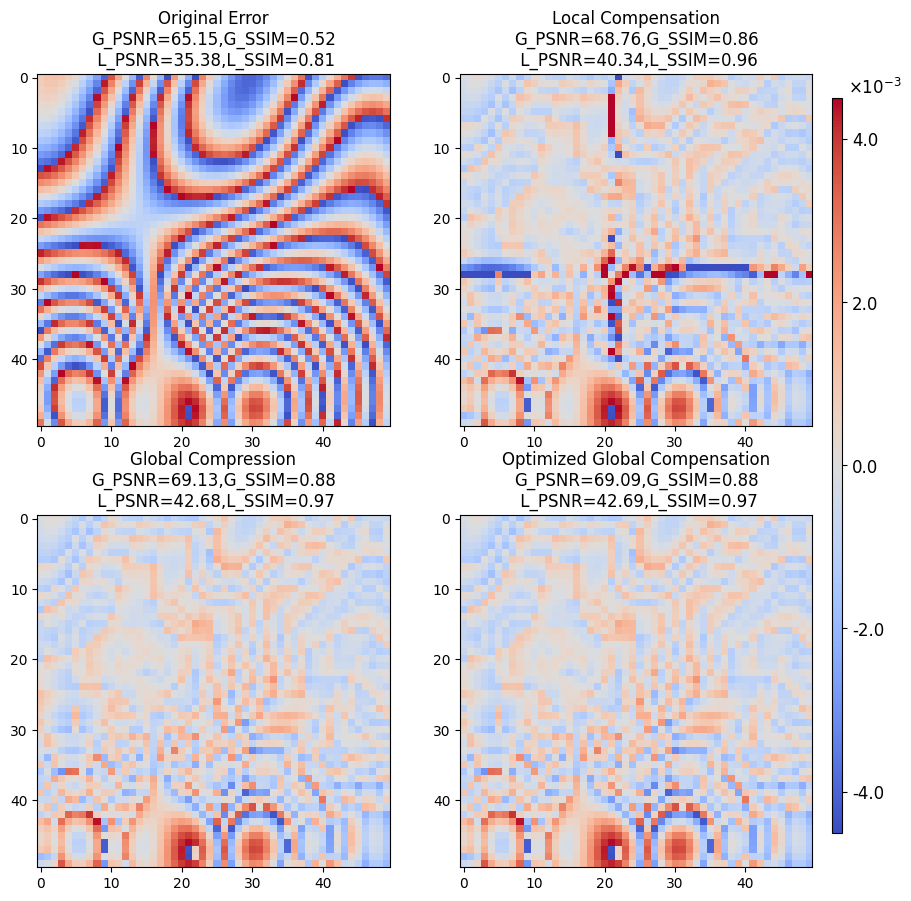

In [81]:
s_xlice = 81
x1 = 260
x2 =  x1+50
y1 = 170  
y2 = y1+50  
local_psnr = []
local_ssim = []
for i in picks :
    local_psnr.append(verify(orig[s_xlice, x1:x2, y1:y2].copy(), decompdessed_data[i][s_xlice, x1:x2, y1:y2].copy()))
    local_ssim.append(qcatssim(orig[s_xlice, x1:x2, y1:y2].copy(), decompdessed_data[i][s_xlice, x1:x2, y1:y2].copy()))
figs, axs = plt.subplots(2, 2, figsize=(10, 10.5))
max_val = np.max(np.abs(e_decomposed[s_xlice, x1:x2, y1:y2]))
min_val = max_val*-1.0
for i in picks: 
    axs[i//2,i%2].imshow(errors[i][s_xlice, x1:x2, y1:y2], cmap='coolwarm', vmin=min_val, vmax=max_val)
    axs[i//2,i%2].set_title(Titles[i]+"\nG_PSNR={:.2f},G_SSIM={:.2f}\n L_PSNR={:.2f},L_SSIM={:.2f}".format(psnr[i], ssim[i],local_psnr[i], local_ssim[i]))
    # axs[i].axis('off')
# plt.colorbar(axs[0].imshow(errors[0][s_xlice, x1:x2, y1:y2], cmap='jet', vmin=min_val, vmax=max_val))
# plt.savefig("error.png", dpi=300)
# put colorbar on the right side of the plot
cbar_ax = figs.add_axes([0.92, 0.15, 0.01, 0.7])
cbar = figs.colorbar(axs[0, 0].imshow(errors[0][s_xlice, x1:x2, y1:y2], 
                                      cmap='coolwarm', vmin=min_val, vmax=max_val), cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  # Set tick label size

# make the colorbar text as scientific notation 
def scientific_fmt(x, pos):
    return f'{x * 1e3:.1f}'  # scale up values so tick labels look like -5.0, ..., 5.0
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter

# formatter = ScalarFormatter(useMathText=True)
# formatter.set_powerlimits((-2, 2))  # Force scientific notation for values outside this range
# cbar.ax.yaxis.set_major_formatter(formatter)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(scientific_fmt))
cbar.ax.yaxis.offsetText.set_visible(False)

cbar.ax.text(1.6, 1.0, r'$\times 10^{-3}$',
             transform=cbar.ax.transAxes,
             fontsize=12,
             ha='left', va='bottom')
plt.show()
figs.savefig("error_vis_zoom_in.pdf",  bbox_inches='tight')

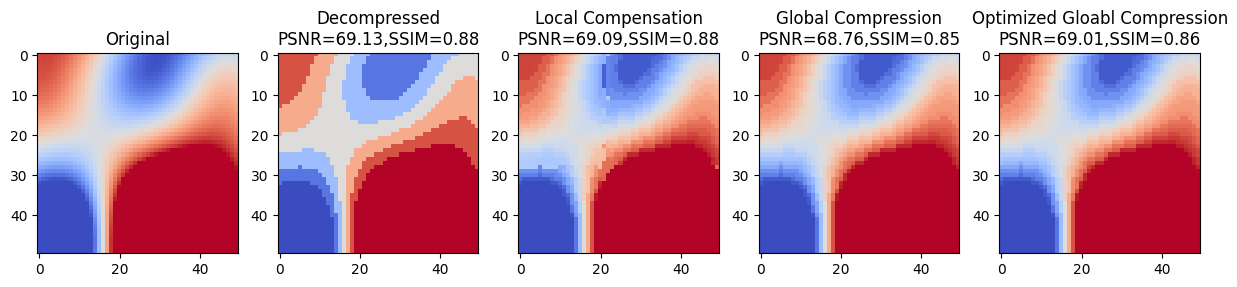

In [88]:
s_xlice = 81
x1 = 260
x2 =  x1+50
y1 = 170  
y2 = y1+50  
local_psnr = []
local_ssim = []
for i in picks :
    local_psnr.append(verify(orig[s_xlice, x1:x2, y1:y2].copy(), decompdessed_data[i][s_xlice, x1:x2, y1:y2].copy()))
    local_ssim.append(qcatssim(orig[s_xlice, x1:x2, y1:y2].copy(), decompdessed_data[i][s_xlice, x1:x2, y1:y2].copy()))
max_val = np.max(np.abs(decompdessed_data[0][s_xlice, x1:x2, y1:y2]))/4
min_val = max_val*-1.0
figs, axs = plt.subplots(1, 5, figsize=(15,3))
plt_data = [orig, decompressed, local_compensation, global_compression, boundary_exchange] 
titles = ["Original", "Decompressed", "Local Compensation", "Global Compression", "Optimized Gloabl Compression"] 

for i in range(5):
    axs[i].imshow(plt_data[i][s_xlice, x1:x2, y1:y2], cmap='coolwarm', vmin=min_val, vmax=max_val)
    if(i ==0): 
        axs[i].set_title(titles[i])
    else: 
        axs[i].set_title(titles[i]+"\nPSNR={:.2f},SSIM={:.2f}".format(psnr[i+1], ssim[i+1]))
    # axs[i].axis('off') 



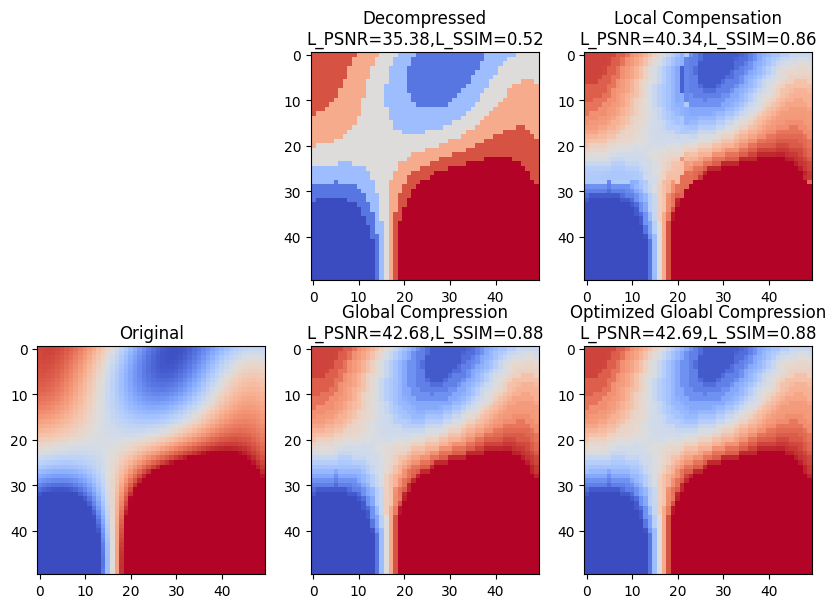

In [103]:
s_xlice = 81
x1 = 260
x2 =  x1+50
y1 = 170  
y2 = y1+50  
local_psnr = []
local_ssim = []
for i in picks :
    local_psnr.append(verify(orig[s_xlice, x1:x2, y1:y2].copy(), decompdessed_data[i][s_xlice, x1:x2, y1:y2].copy()))
    local_ssim.append(qcatssim(orig[s_xlice, x1:x2, y1:y2].copy(), decompdessed_data[i][s_xlice, x1:x2, y1:y2].copy()))
max_val = np.max(np.abs(decompdessed_data[0][s_xlice, x1:x2, y1:y2]))/4
min_val = max_val*-1.0
figs, axs = plt.subplots(2, 3, figsize=(10,7))
plt_data = [orig, decompressed, local_compensation, global_compression, boundary_exchange] 
titles = ["Original", "Decompressed", "Local Compensation", "Global Compression", "Optimized Gloabl Compression"] 

# axs[0,0].imshow(plt_data[0][s_xlice, x1:x2, y1:y2], cmap='coolwarm', vmin=min_val, vmax=max_val)
# axs[0,0].set_title(titles[0])
axs[0,1].imshow(plt_data[1][s_xlice, x1:x2, y1:y2], cmap='coolwarm', vmin=min_val, vmax=max_val)
axs[0,1].set_title(titles[1]+"\nL_PSNR={:.2f},L_SSIM={:.2f}".format(local_psnr[0], ssim[0]))
axs[0,2].imshow(plt_data[2][s_xlice, x1:x2, y1:y2], cmap='coolwarm', vmin=min_val, vmax=max_val)
axs[0,2].set_title(titles[2]+"\nL_PSNR={:.2f},L_SSIM={:.2f}".format(local_psnr[1], ssim[1]))
axs[1,1].imshow(plt_data[3][s_xlice, x1:x2, y1:y2], cmap='coolwarm', vmin=min_val, vmax=max_val)
axs[1,1].set_title(titles[3]+"\nL_PSNR={:.2f},L_SSIM={:.2f}".format(local_psnr[2], ssim[2]))
axs[1,2].imshow(plt_data[4][s_xlice, x1:x2, y1:y2], cmap='coolwarm', vmin=min_val, vmax=max_val)
axs[1,2].set_title(titles[4]+"\nL_PSNR={:.2f},L_SSIM={:.2f}".format(local_psnr[3], ssim[3]))
# axs[1,0].axis('off')
    # axs[i].axis('off')
    

# for i in range(5):
#     axs[i].imshow(plt_data[i][s_xlice, x1:x2, y1:y2], cmap='coolwarm', vmin=min_val, vmax=max_val)
#     if(i ==0): 
#         axs[i].set_title(titles[i])
#     else: 
#         axs[i].set_title(titles[i]+"\nPSNR={:.2f},SSIM={:.2f}".format(psnr[i+1], ssim[i+1]))
#     # axs[i].axis('off') 
axs[0,0].axis('off')  # Empty top-left

axs[1,0].imshow(plt_data[0][s_xlice, x1:x2, y1:y2], cmap='coolwarm', vmin=min_val, vmax=max_val)
axs[1,0].set_title(titles[0])
figs.savefig("data_vis_zoom_in.pdf",  bbox_inches='tight')

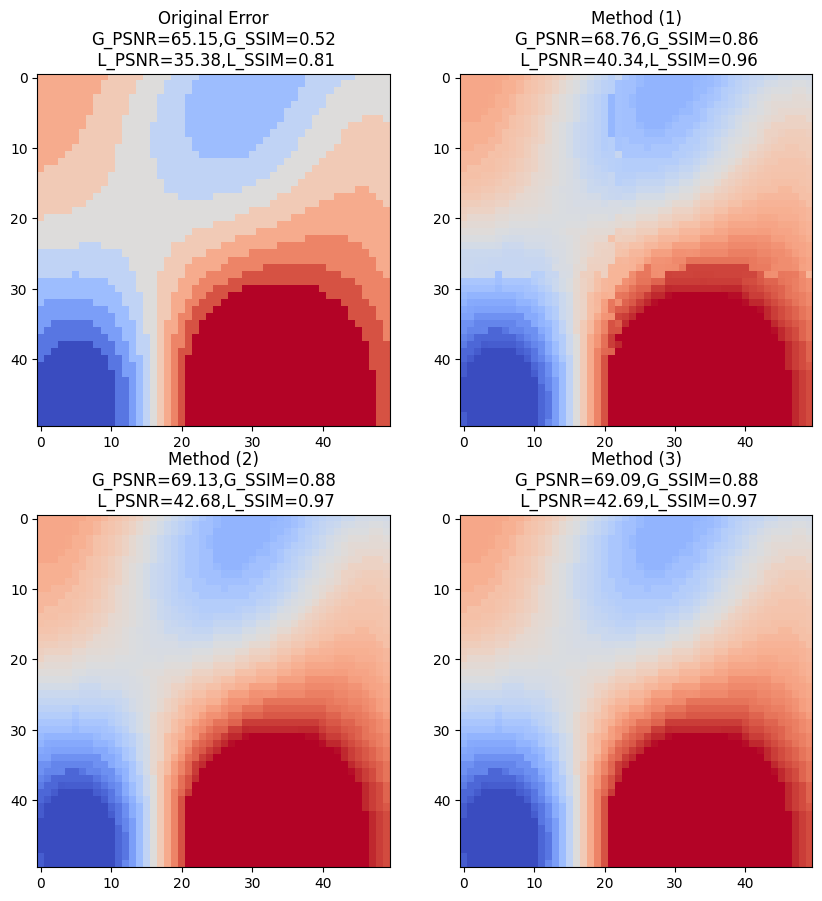

In [78]:
s_xlice = 81
x1 = 260
x2 =  x1+50
y1 = 170  
y2 = y1+50  
local_psnr = []
local_ssim = []
for i in picks :
    local_psnr.append(verify(orig[s_xlice, x1:x2, y1:y2].copy(), decompdessed_data[i][s_xlice, x1:x2, y1:y2].copy()))
    local_ssim.append(qcatssim(orig[s_xlice, x1:x2, y1:y2].copy(), decompdessed_data[i][s_xlice, x1:x2, y1:y2].copy()))
figs, axs = plt.subplots(2, 2, figsize=(10, 10.5))
max_val = np.max(np.abs(decompdessed_data[0][s_xlice, x1:x2, y1:y2]))/2
min_val = max_val*-1.0
for i in picks: 
    axs[i//2,i%2].imshow(decompdessed_data[i][s_xlice, x1:x2, y1:y2], cmap='coolwarm', vmin=min_val, vmax=max_val)
    axs[i//2,i%2].set_title(Titles[i]+"\nG_PSNR={:.2f},G_SSIM={:.2f}\n L_PSNR={:.2f},L_SSIM={:.2f}".format(psnr[i], ssim[i],local_psnr[i], local_ssim[i]))
    # axs[i].axis('off')
# plt.colorbar(axs[0].imshow(errors[0][s_xlice, x1:x2, y1:y2], cmap='jet', vmin=min_val, vmax=max_val))
# plt.savefig("error.png", dpi=300)
# put colorbar on the right side of the plot
# cbar_ax = figs.add_axes([0.92, 0.15, 0.01, 0.7])
# cbar = figs.colorbar(axs[0, 0].imshow(errors[0][s_xlice, x1:x2, y1:y2], 
#                                       cmap='coolwarm', vmin=min_val, vmax=max_val), cax=cbar_ax)
# cbar.ax.tick_params(labelsize=12)  # Set tick label size

# # make the colorbar text as scientific notation 
# def scientific_fmt(x, pos):
#     return f'{x :.1f}'  # scale up values so tick labels look like -5.0, ..., 5.0
# from matplotlib.ticker import ScalarFormatter
# from matplotlib.ticker import FuncFormatter

# # formatter = ScalarFormatter(useMathText=True)
# # formatter.set_powerlimits((-2, 2))  # Force scientific notation for values outside this range
# # cbar.ax.yaxis.set_major_formatter(formatter)
# cbar.ax.yaxis.set_major_formatter(FuncFormatter(scientific_fmt))
# cbar.ax.yaxis.offsetText.set_visible(False)

# cbar.ax.text(1.6, 1.0, r'$\times 10^{-3}$',
#              transform=cbar.ax.transAxes,
#              fontsize=12,
#              ha='left', va='bottom')
plt.show()
figs.savefig("error_vis_zoom_in.pdf",  bbox_inches='tight')

In [ ]:
s_xlice = 81
x1 = 260
x2 =  x1+50
y1 = 170  
y2 = y1+50  
local_psnr = []
local_ssim = []
for i in picks :
    local_psnr.append(verify(orig[s_xlice, x1:x2, y1:y2].copy(), decompdessed_data[i][s_xlice, x1:x2, y1:y2].copy()))
    local_ssim.append(qcatssim(orig[s_xlice, x1:x2, y1:y2].copy(), decompdessed_data[i][s_xlice, x1:x2, y1:y2].copy()))
figs, axs = plt.subplots(2, 2, figsize=(10, 10.5))
max_val = np.max(np.abs(e_decomposed[s_xlice, x1:x2, y1:y2]))
min_val = max_val*-1.0
for i in picks: 
    axs[i//2,i%2].imshow(errors[i][s_xlice, x1:x2, y1:y2], cmap='coolwarm', vmin=min_val, vmax=max_val)
    axs[i//2,i%2].set_title(Titles[i]+"\nG_PSNR={:.2f},G_SSIM={:.2f}\n L_PSNR={:.2f},L_SSIM={:.2f}".format(psnr[i], ssim[i],local_psnr[i], local_ssim[i]))
    # axs[i].axis('off')
# plt.colorbar(axs[0].imshow(errors[0][s_xlice, x1:x2, y1:y2], cmap='jet', vmin=min_val, vmax=max_val))
# plt.savefig("error.png", dpi=300)
# put colorbar on the right side of the plot
cbar_ax = figs.add_axes([0.92, 0.15, 0.01, 0.7])
cbar = figs.colorbar(axs[0, 0].imshow(errors[0][s_xlice, x1:x2, y1:y2], 
                                      cmap='coolwarm', vmin=min_val, vmax=max_val), cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  # Set tick label size

# make the colorbar text as scientific notation 
def scientific_fmt(x, pos):
    return f'{x * 1e3:.1f}'  # scale up values so tick labels look like -5.0, ..., 5.0
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter

# formatter = ScalarFormatter(useMathText=True)
# formatter.set_powerlimits((-2, 2))  # Force scientific notation for values outside this range
# cbar.ax.yaxis.set_major_formatter(formatter)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(scientific_fmt))
cbar.ax.yaxis.offsetText.set_visible(False)

cbar.ax.text(1.6, 1.0, r'$\times 10^{-3}$',
             transform=cbar.ax.transAxes,
             fontsize=12,
             ha='left', va='bottom')
plt.show()
figs.savefig("error_vis_zoom_in.pdf",  bbox_inches='tight')

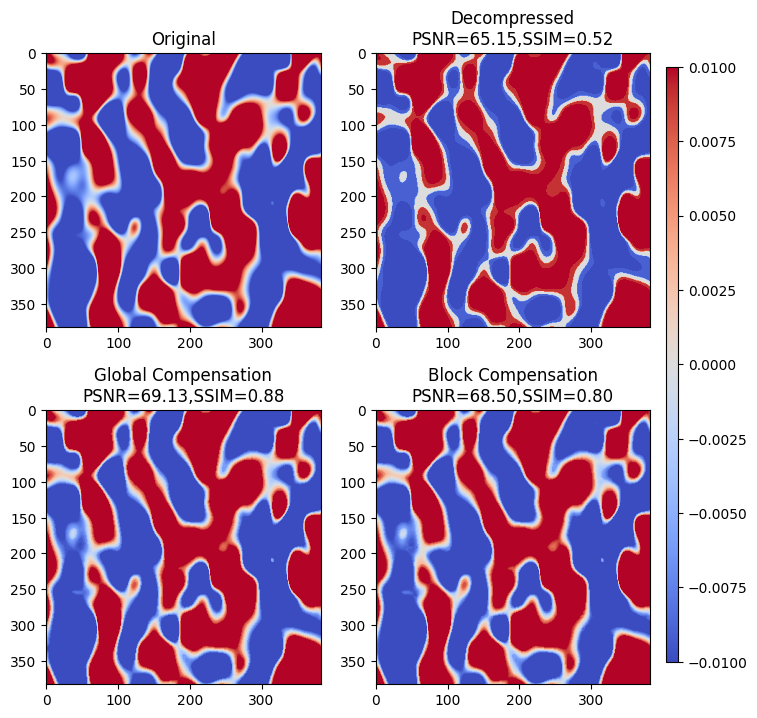

In [4]:
s_xlice = 81
x1 = 0
x2 = -1
y1 = 0
y2 = -1 
figs, axs = plt.subplots(2, 2, figsize=(8, 8.5)) 
# max_val = np.max(orig[s_xlice, x1:x2, y1:y2])/2
max_val =0.01 
# min_val = -np.min(orig[s_xlice, x1:x2, y1:y2])/2
min_val = max_val * -1
axs[0, 0].imshow(orig[s_xlice, x1:x2, y1:y2], cmap='coolwarm', vmin=min_val, vmax=max_val)
axs[0, 0].set_title("Original")
axs[0, 1].imshow(decompressed[s_xlice, x1:x2, y1:y2], cmap='coolwarm', vmin=min_val, vmax=max_val)
axs[0, 1].set_title("Decompressed\nPSNR={:.2f},SSIM={:.2f}".format(psnr[0], ssim[0]))
axs[1, 0].imshow(global_compression[s_xlice, x1:x2, y1:y2], cmap='coolwarm', vmin=min_val, vmax=max_val)
axs[1, 0].set_title("Global Compensation\nPSNR={:.2f},SSIM={:.2f}".format(psnr[1], ssim[1]))
axs[1, 1].imshow(block_compression[s_xlice, x1:x2, y1:y2], cmap='coolwarm', vmin=min_val, vmax=max_val)
axs[1, 1].set_title("Block Compensation\nPSNR={:.2f},SSIM={:.2f}".format(psnr[2], ssim[2]))
# share a colorbar on the right side 
figs.subplots_adjust(right=0.88)
cbar_ax = figs.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = figs.colorbar(axs[0, 0].images[0], cax=cbar_ax)
figs.savefig("visualization-data.pdf", bbox_inches='tight')

/home/pji228/tmp/ipykernel_166203/1583191525.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  figs.tight_layout()


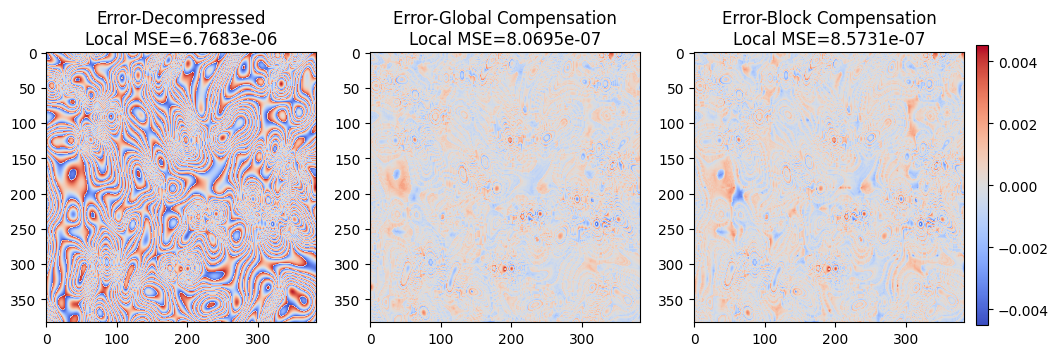

In [5]:
e_o = orig-decompressed
e_g = orig-global_compression
e_b = orig-block_compression
figs2, axs2 = plt.subplots(1, 3, figsize=(12, 4))
max_val = np.max(np.abs(e_o[s_xlice, x1:x2, y1:y2]))
# min_val = np.min(e_o[s_xlice, x1:x2, y1:y2])
min_val = max_val*-1.0
axs2[0].imshow(e_o[s_xlice, x1:x2, y1:y2], cmap='coolwarm', vmin=min_val, vmax=max_val)
axs2[0].set_title("Error-Decompressed\nLocal MSE={:.4e}".format(np.mean(e_o[s_xlice, x1:x2, y1:y2]**2)))
axs2[1].imshow(e_g[s_xlice, x1:x2, y1:y2], cmap='coolwarm', vmin=min_val, vmax=max_val)
axs2[1].set_title("Error-Global Compensation\nLocal MSE={:.4e}".format(np.mean(e_g[s_xlice, x1:x2, y1:y2]**2)))
axs2[2].imshow(e_b[s_xlice, x1:x2, y1:y2], cmap='coolwarm', vmin=min_val, vmax=max_val)
axs2[2].set_title("Error-Block Compensation\nLocal MSE={:.4e}".format(np.mean(e_b[s_xlice, x1:x2, y1:y2]**2)))
figs.tight_layout()
# figs2.tight_layout()
# add colorbar to the right side 
figs2.subplots_adjust(right=0.89)
cbar_ax = figs2.add_axes([0.9, 0.15, 0.01, 0.7])
cbar = figs2.colorbar(axs2[0].images[0], cax=cbar_ax)
figs2.savefig("visualization-error.pdf", bbox_inches='tight')


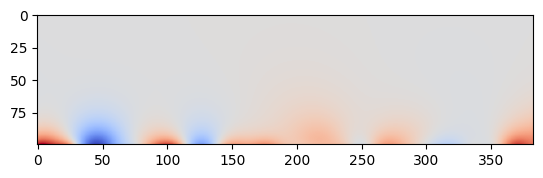

In [17]:
plt.imshow(orig[0:100,0:-1,0], cmap='coolwarm') 

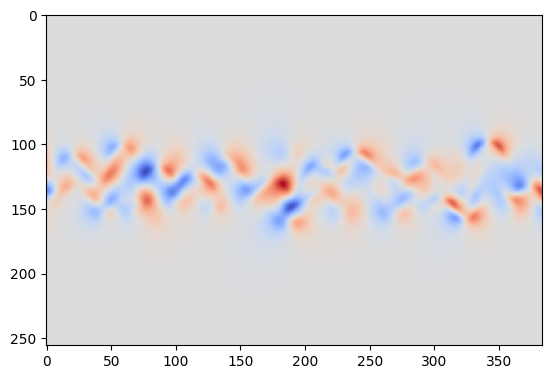

In [74]:
plt.imshow(orig[:,0,:], cmap='coolwarm') 

In [35]:
import os
x1 = 100
x2 = 160 
roi_data = orig[x1:x2,:,:]
shape1= roi_data.shape[0]
roi_data.astype(np.float32).tofile("roi_data.f32")
eb = 0.001
command_line = f"/scratch/pji228/gittmp/posterization_mitigation/build/test/test_quantize_and_edt  \
                 3 {shape1} 384 384 roi_data.f32 {eb} roi_data.f32.dec roi_data.f32.dec.compensated_data.f32"
os.system(command_line)

max: 2.297243, min: -2.214255
relative eb: 0.001000
absolute eb: 0.004511
Min=-2.2142553329467773438, Max=2.2972428798675537109, range=4.5114982128143310547
Max absolute error = 0.0045
Max relative error = 0.001
Max pw relative error = 1
PSNR = 64.770563, NRMSE= 0.0005773934512
normError = 7.748176, normErr_norm = 0.006202
acEff=0.999981
SSE=60.034236
MSE=0.000007
SSIM = 0.999589
aux time = 0.000009 
cache line allocation time = 0.000007
edt total time = 0.995779
edt time = 0.9486318130 
distance time = 0.0468341
aux time = 0.000017 
cache line allocation time = 0.000004
edt time = 1.02898
compensation map size = 8847360
compensation time = 2.6926
Min=-2.2142553329467773438, Max=2.2972428798675537109, range=4.5114982128143310547
Max absolute error = 0.0085
Max relative error = 0.0019
Max pw relative error = 5.9E+02
PSNR = 64.789198, NRMSE= 0.0005761560074
normError = 7.731571, normErr_norm = 0.006188
acEff=0.999981
SSE=59.777186
MSE=0.000007
SSIM = 0.999628


0

Text(0.5, 0.98, 'ROI x1=100 - 160')

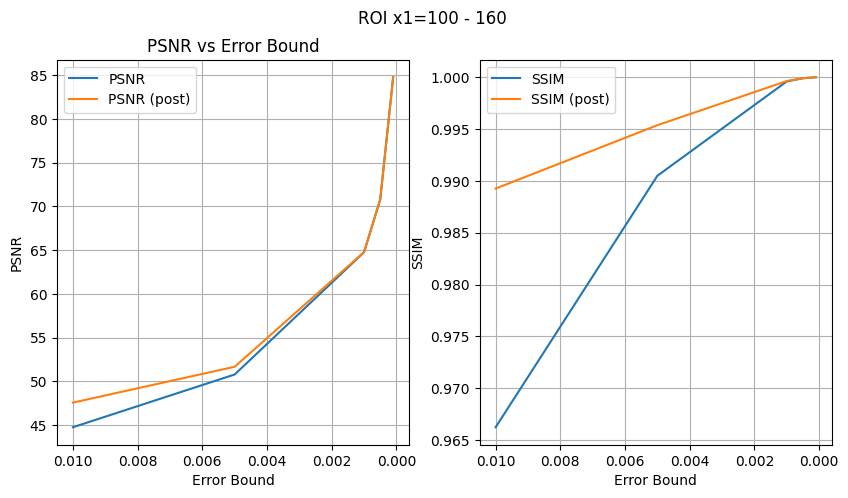

In [62]:
ebs = [0.0001, 0.0005, 0.001, 0.005, 0.01]
psnrs = [84.771945, 70.791747,64.770563,50.792931, 44.767258] 
post_psnrs = [84.771890 , 70.793140,64.789198,51.677589,47.579063]
ssim =[0.999996,0.999897,0.999589,0.990490,0.966233 ]
post_ssim = [0.999996, 0.999899,0.999628,0.995368,0.989257 ] 
figs, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(ebs, psnrs, label='PSNR')
axs[0].plot(ebs, post_psnrs, label='PSNR (post)')
axs[0].set_xlabel('Error Bound')
axs[0].set_ylabel('PSNR')
axs[0].legend()
axs[0].set_title('PSNR vs Error Bound')
axs[0].invert_xaxis()
axs[1].plot(ebs, ssim, label='SSIM')
axs[1].plot(ebs, post_ssim, label='SSIM (post)')
axs[1].set_xlabel('Error Bound')
axs[1].set_ylabel('SSIM')
axs[1].legend()
axs[1].invert_xaxis()
axs[0].grid()
axs[1].grid()
plt.suptitle('ROI x1=100 - 160')

In [ ]:
import os
x1 = 0
x2 = 100 
roi_data = orig[x1:x2,:,:]
shape1= roi_data.shape[0]
roi_data.astype(np.float32).tofile("roi_data.f32")
eb = 0.005
command_line = f"/scratch/pji228/gittmp/posterization_mitigation/build/test/test_quantize_and_edt  \
                 3 {shape1} 384 384 roi_data.f32 {eb} roi_data.f32.dec roi_data.f32.dec.compensated_data.f32"
os.system(command_line)

Text(0.5, 0.98, 'ROI x = 0-100')

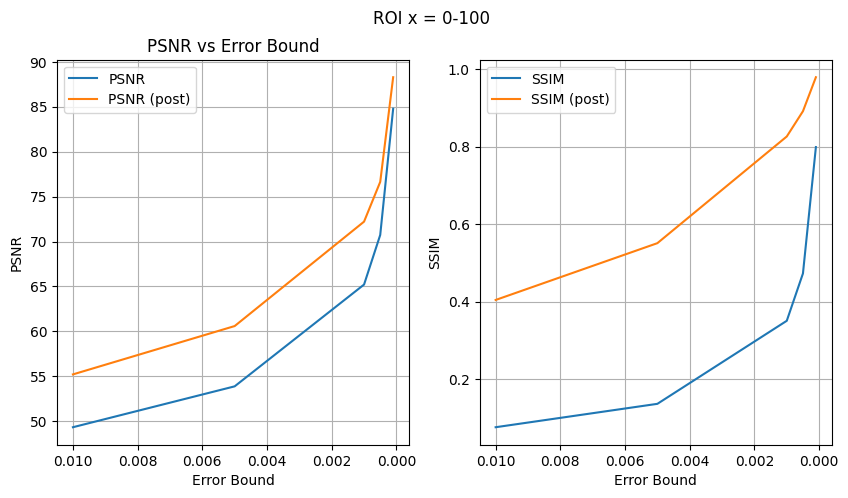

In [63]:
ebs = [0.0001, 0.0005, 0.001, 0.005, 0.01]
psnrs = [84.779506,70.734187, 65.213775,53.888710, 49.341307] 
post_psnrs = [88.282004, 76.637125, 72.214452,60.595876,55.217835 ]
ssim =[ 0.798861, 0.472589, 0.350414,0.136005,0.075625 ]
post_ssim = [ 0.979238 , 0.891477 ,0.826248,0.550826,0.404167] 
figs, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(ebs, psnrs, label='PSNR')
axs[0].plot(ebs, post_psnrs, label='PSNR (post)')
axs[0].set_xlabel('Error Bound')
axs[0].set_ylabel('PSNR')
axs[0].legend()
axs[0].set_title('PSNR vs Error Bound')
axs[0].invert_xaxis()
axs[1].plot(ebs, ssim, label='SSIM')
axs[1].plot(ebs, post_ssim, label='SSIM (post)')
axs[1].set_xlabel('Error Bound')
axs[1].set_ylabel('SSIM')
axs[1].legend()
axs[1].invert_xaxis()
axs[0].grid()
axs[1].grid()
plt.suptitle('ROI x = 0-100')


In [ ]:
import os
x1 = 160
x2 = -1 
roi_data = orig[x1:x2,:,:]
shape1= roi_data.shape[0]
roi_data.astype(np.float32).tofile("roi_data.f32")
eb = 0.01
command_line = f"/scratch/pji228/gittmp/posterization_mitigation/build/test/test_quantize_and_edt  \
                 3 {shape1} 384 384 roi_data.f32 {eb} roi_data.f32.dec roi_data.f32.dec.compensated_data.f32"
os.system(command_line)

Text(0.5, 0.98, 'ROI x = 160:256')

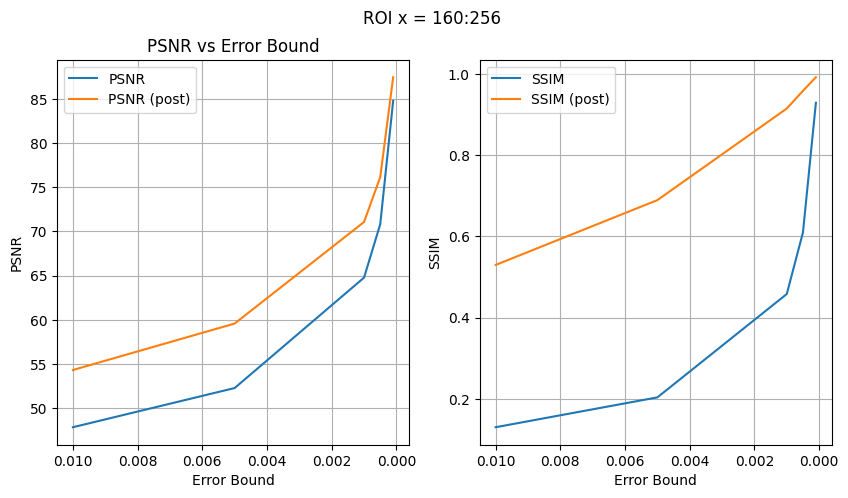

In [65]:
ebs = [0.0001, 0.0005, 0.001, 0.005, 0.01]
psnrs = [84.769152, 70.800222, 64.766034, 52.271900,47.838482 ] 
post_psnrs = [87.440045, 76.131576,  71.059536,59.568244,54.314121 ]
ssim =[ 0.929251, 0.609612, 0.458095, 0.203467,0.129943 ]
post_ssim = [0.992183,  0.958607,0.915039,0.689441, 0.529703] 
figs, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(ebs, psnrs, label='PSNR')
axs[0].plot(ebs, post_psnrs, label='PSNR (post)')
axs[0].set_xlabel('Error Bound')
axs[0].set_ylabel('PSNR')
axs[0].legend()
axs[0].set_title('PSNR vs Error Bound')
axs[0].invert_xaxis()
axs[1].plot(ebs, ssim, label='SSIM')
axs[1].plot(ebs, post_ssim, label='SSIM (post)')
axs[1].set_xlabel('Error Bound')
axs[1].set_ylabel('SSIM')
axs[1].legend()
axs[1].invert_xaxis()
axs[0].grid()
axs[1].grid()
plt.suptitle('ROI x = 160:256')

In [ ]:
import os
x1 = 0
x2 = 256 
roi_data = orig[x1:x2,:,:]
shape1= roi_data.shape[0]
roi_data.astype(np.float32).tofile("roi_data.f32")
eb = 0.01
command_line = f"/scratch/pji228/gittmp/posterization_mitigation/build/test/test_quantize_and_edt  \
                 3 {shape1} 384 384 roi_data.f32 {eb} roi_data.f32.dec roi_data.f32.dec.compensated_data.f32 32"
os.system(command_line)

Text(0.5, 0.98, 'Whole Domain')

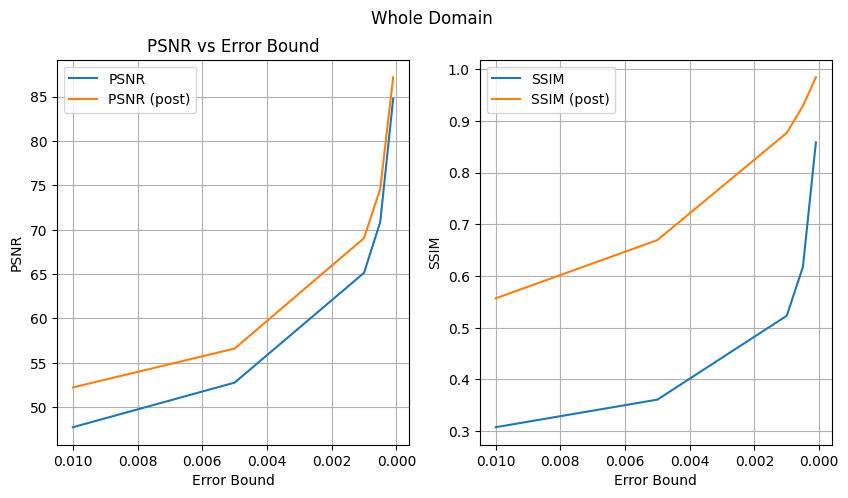

In [73]:
ebs = [0.0001, 0.0005, 0.001, 0.005, 0.01]
psnrs = [84.773688,70.858707, 65.146515, 52.767548,47.738627 ] 
post_psnrs = [87.197601,74.606451, 69.063744, 56.609003, 52.224016 ]
ssim =[  0.858306,0.618014, 0.523204, 0.361037 ,0.307720 ]
post_ssim = [0.984301,0.928904, 0.876673, 0.669451 , 0.556851] 
figs, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(ebs, psnrs, label='PSNR')
axs[0].plot(ebs, post_psnrs, label='PSNR (post)')
axs[0].set_xlabel('Error Bound')
axs[0].set_ylabel('PSNR')
axs[0].legend()
axs[0].set_title('PSNR vs Error Bound')
axs[0].invert_xaxis()
axs[1].plot(ebs, ssim, label='SSIM')
axs[1].plot(ebs, post_ssim, label='SSIM (post)')
axs[1].set_xlabel('Error Bound')
axs[1].set_ylabel('SSIM')
axs[1].legend()
axs[1].invert_xaxis()
axs[0].grid()
axs[1].grid()
plt.suptitle('Whole Domain') 